<a href="https://colab.research.google.com/github/99ffx/Atlas-Segmentation/blob/main/ATLAS_LAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Registration and Transformix using Elastix

In [5]:
# !pip install itk-elastix

In [6]:
# !pip install itkwidgets

In [2]:
import itk
import nibabel as nib
import matplotlib.pyplot  as plt
import os
import numpy as np
from glob import glob
from tqdm import tqdm

## File Manager

In [3]:
training_img_path = "/content/drive/MyDrive/MIRA/Atlas Lab/image/training-images"
training_label_path = "/content/drive/MyDrive/MIRA/Atlas Lab/image/training-labels"
output_dir = "/content/drive/MyDrive/MIRA/Atlas Lab/results"
param_affine_path = "/content/drive/MyDrive/MIRA/Atlas Lab/Par0010affine.txt"
param_bspline_path = "/content/drive/MyDrive/MIRA/Atlas Lab/Par0010bspline.txt"

training_volumes = sorted(glob(os.path.join(training_img_path,'**','*.nii.gz'), recursive = True))
training_labels = sorted(glob(os.path.join(training_label_path,'**','*.nii.gz'), recursive = True))

fixed_image_path = os.path.join(training_img_path, "1000.nii.gz")
fixed_image = itk.imread(fixed_image_path, itk.F)

In [4]:
parameter_object = itk.ParameterObject.New()
# STAGE1 AFFINE PARAM
parameter_object.AddParameterFile(param_affine_path)

# STAGE2 BPLINE PARAM
parameter_object.AddParameterFile(param_bspline_path)

# SAVE PARAMETER FILES
parameter_object.SetParameter(0,"ResampleInterpolator", "FinalNearestNeighborInterpolator")
parameter_object.SetParameter(1,"ResampleInterpolator", "FinalNearestNeighborInterpolator")

print(parameter_object)

ParameterObject (0x5b3360497d50)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 64
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (AutomaticScalesEstimation "true")
  (AutomaticTransformInitialization "true")
  (AutomaticTransformInitializationMethod "CenterOfGravity")
  (BSplineInterpolationOrder 1)
  (CheckNumberOfSamples "true")
  (CompressResultImage "true")
  (DefaultPixelValue 0)
  (ErodeMask "false")
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedImagePyramid "FixedSmoothingImagePyramid")
  (FixedInternalImagePixelType "float")
  (FixedKernelBSplineOrder 3)
  (FixedLimitRangeRatio 0)
  (HowToCombineTransforms "Compose")
  (ImageSampler "Random")
  (Interpolator "BSplineInterpolator")
  (MaximumNumberOfIterations 1000)
  (MaximumNumberOfSamplingAttempts 10)
  (MaximumStepLength 4)
  (Metric "AdvancedMattesMutualInformation")
  (MovingImageDimension 3)
  (MovingImagePyramid "MovingSmoothingImagePyra

## Registeration and Transformix

In [ ]:
for moving_img_path, label_path in tqdm(zip(training_volumes,training_labels)):
  if "1000.nii.gz" in moving_img_path or "1000_3C.nii.gz" in label_path:
    continue
  moving_image = itk.imread(moving_img_path, itk.F)
  transform_label = itk.imread(label_path, itk.F)

  # Perform registration
  result_image, result_transform_parameters = itk.elastix_registration_method( fixed_image, moving_image,parameter_object=parameter_object, log_to_console=False )
  # Save register img
  moving_image_name = os.path.basename(moving_img_path).replace(".nii.gz", "")
  file_name = f'registered_{moving_image_name}.nii.gz'
  full_save_path = os.path.join(output_dir, file_name)
  itk.imwrite(result_image,full_save_path)

  #Transformix
  result_image_transformix = itk.transformix_filter( transform_label,result_transform_parameters)
  # Save the transformed label image
  transformed_label_path = os.path.join(output_dir, f'transformed_label_{moving_image_name}.nii.gz')
  itk.imwrite(result_image_transformix, transformed_label_path)

11it [38:40, 230.13s/it]

Fixed image shape: (256, 287, 256)
Registered image shape: (256, 277, 256)


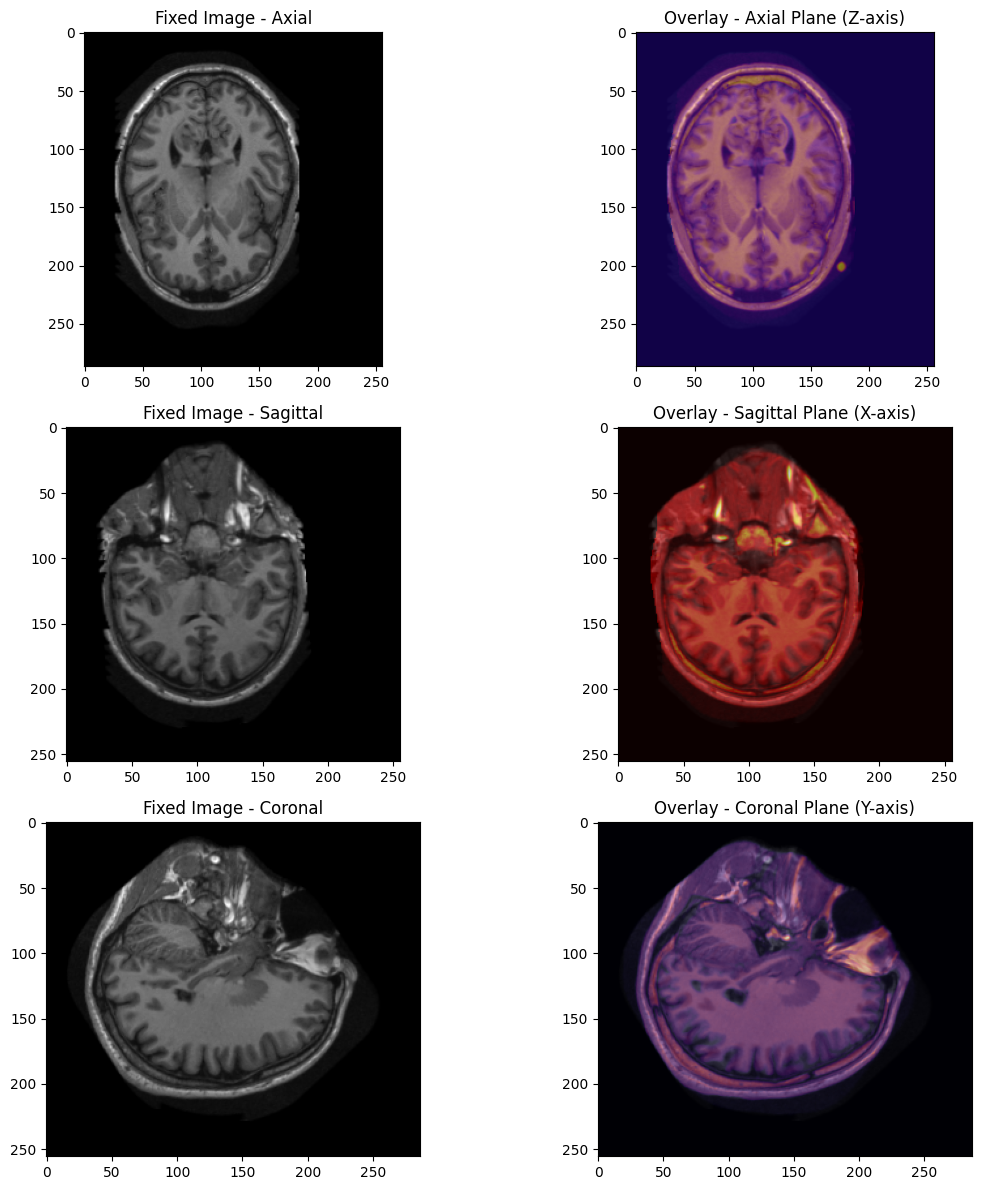

In [22]:
print(f"Fixed image shape: {fixed_image.shape}")
print(f"Registered image shape: {moving_image.shape}")

# Extract slices from both fixed and registered images for overlay
axial_fixed_slice = fixed_image[fixed_image.shape[0] // 2, :, :]
sagittal_fixed_slice = fixed_image[:, fixed_image.shape[1] // 2, :]
coronal_fixed_slice = fixed_image[:, :, fixed_image.shape[2] // 2]

axial_registered_slice = result_image[result_image.shape[0] // 2, :, :]
sagittal_registered_slice = result_image[:, result_image.shape[1] // 2, :]
coronal_registered_slice = result_image[:, :, result_image.shape[2] // 2]

# Plot the slices with overlays
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Axial plane
axs[0, 0].imshow(axial_fixed_slice, cmap='gray')
axs[0, 0].set_title('Fixed Image - Axial')
axs[0, 1].imshow(axial_fixed_slice, cmap='gray')
axs[0, 1].imshow(axial_registered_slice, cmap='plasma', alpha=0.5)  # Overlay with registered image
axs[0, 1].set_title('Overlay - Axial Plane (Z-axis)')

# Sagittal plane
axs[1, 0].imshow(sagittal_fixed_slice, cmap='gray')
axs[1, 0].set_title('Fixed Image - Sagittal')
axs[1, 1].imshow(sagittal_fixed_slice, cmap='gray')
axs[1, 1].imshow(sagittal_registered_slice, cmap='hot', alpha=0.5)  # Overlay with registered image
axs[1, 1].set_title('Overlay - Sagittal Plane (X-axis)')

# Coronal plane
axs[2, 0].imshow(coronal_fixed_slice, cmap='gray')
axs[2, 0].set_title('Fixed Image - Coronal')
axs[2, 1].imshow(coronal_fixed_slice, cmap='gray')
axs[2, 1].imshow(coronal_registered_slice, cmap='magma', alpha=0.5)  # Overlay with registered image
axs[2, 1].set_title('Overlay - Coronal Plane (Y-axis)')

plt.tight_layout()
plt.show()

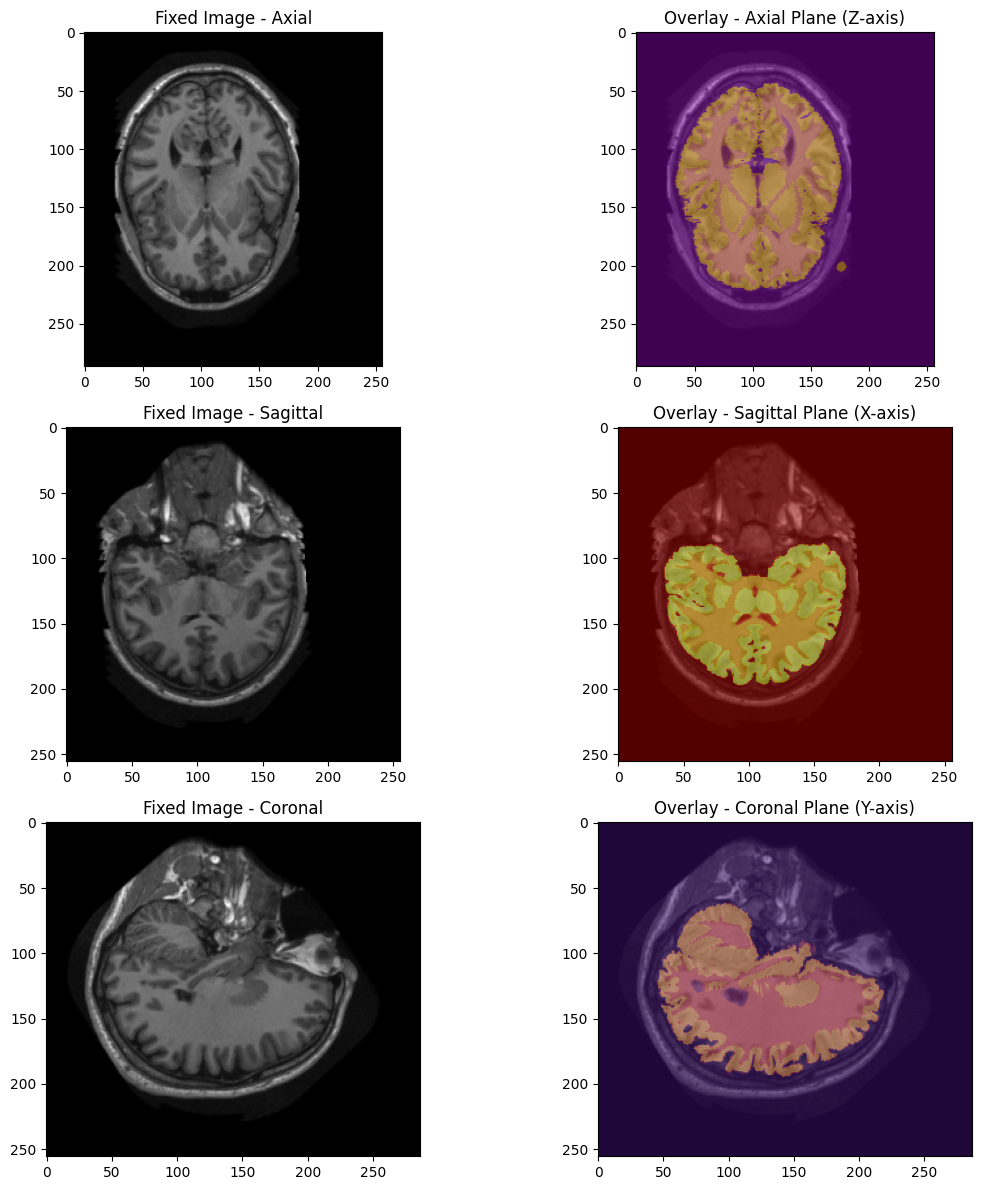

In [27]:

# Extract slices from both fixed and registered images for overlay
axial_fixed_slice = fixed_image[fixed_image.shape[0] // 2, :, :]
sagittal_fixed_slice = fixed_image[:, fixed_image.shape[1] // 2, :]
coronal_fixed_slice = fixed_image[:, :, fixed_image.shape[2] // 2]

axial_registered_slice = result_image_transformix[result_image_transformix.shape[0] // 2, :, :]
sagittal_registered_slice = result_image_transformix[:, result_image_transformix.shape[1] // 2, :]
coronal_registered_slice = result_image_transformix[:, :, result_image_transformix.shape[2] // 2]

# Plot the slices with overlays
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Axial plane
axs[0, 0].imshow(axial_fixed_slice, cmap='gray')
axs[0, 0].set_title('Fixed Image - Axial')
axs[0, 1].imshow(axial_fixed_slice, cmap='gray')
axs[0, 1].imshow(axial_registered_slice, cmap='plasma', alpha=0.5)  # Overlay with registered image
axs[0, 1].set_title('Overlay - Axial Plane (Z-axis)')

# Sagittal plane
axs[1, 0].imshow(sagittal_fixed_slice, cmap='gray')
axs[1, 0].set_title('Fixed Image - Sagittal')
axs[1, 1].imshow(sagittal_fixed_slice, cmap='gray')
axs[1, 1].imshow(sagittal_registered_slice, cmap='hot', alpha=0.5)  # Overlay with registered image
axs[1, 1].set_title('Overlay - Sagittal Plane (X-axis)')

# Coronal plane
axs[2, 0].imshow(coronal_fixed_slice, cmap='gray')
axs[2, 0].set_title('Fixed Image - Coronal')
axs[2, 1].imshow(coronal_fixed_slice, cmap='gray')
axs[2, 1].imshow(coronal_registered_slice, cmap='magma', alpha=0.5)  # Overlay with registered image
axs[2, 1].set_title('Overlay - Coronal Plane (Y-axis)')

plt.tight_layout()
plt.show()